In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append('..')
from lib import *
from common import labels, model_hierarchy

plt.style.use('../peptidome.mplstyle')

In [21]:
L = 9


In [22]:
datasets = ['train', 'test', 'independent']
datasets.extend(model_hierarchy)
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] = load_matrix('data/%s_matrix_L%i.csv.gz' % (dataset, L))

In [24]:
params = np.load('data/Human_model_9.npz')
hi = params['hi']
Jij = params['Jij']

@njit
def energy(x):
    return energy_potts(x, hi, Jij)

In [25]:
params = np.load('data/Human_nskew_9.npz')
h = params['h']
J = params['J']
J2 = params['J2']
@njit
def energy(x):
    return energy_nskew(x, h=h, J=J, J2=J2)

In [11]:
params = np.load('data/Human_nskewfcov_9.npz')
h = params['h']
J = params['J']
J2 = params['J2']
hi = params['hi']
Jij = params['Jij']
@njit
def energy(x):
    return energy_nskewfcov(x, h=h, J=J, J2=J2, hi=hi, Jij=Jij)

KeyError: 'hi is not a file in the archive'

In [26]:
energies = {}
datasets = ['test', 'independent']
datasets.extend(model_hierarchy)
for dataset in datasets:
    energies[dataset] = np.array([energy(x) for x in sample_matrices[dataset]])

In [27]:
len(energies['test']), len(energies['model']), len(energies['model_ncov'])

(5367489, 5421764, 5421764)

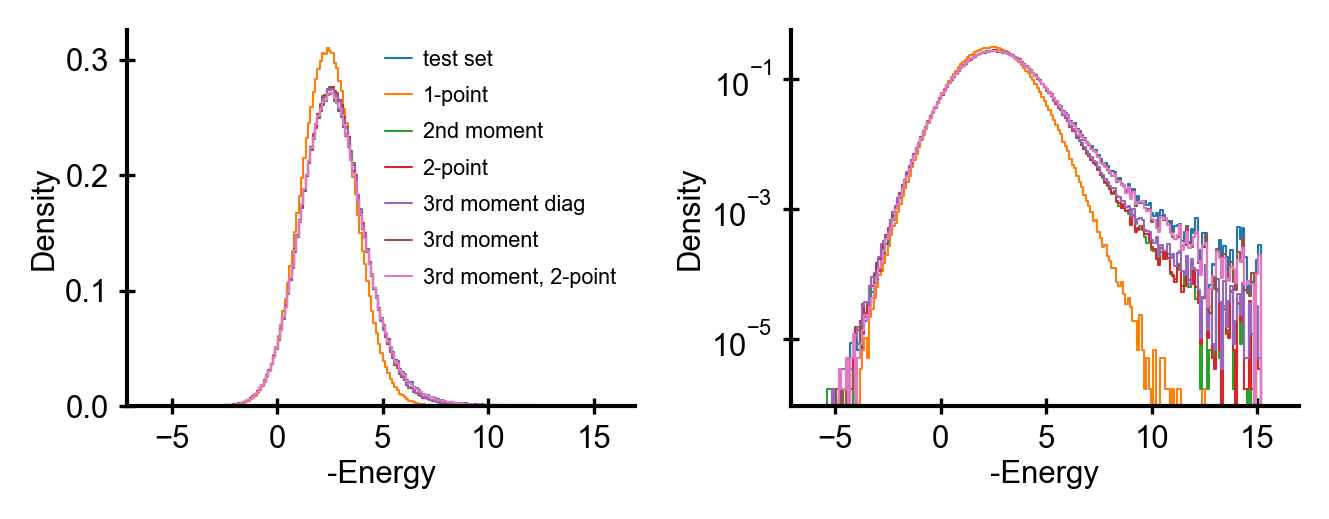

In [28]:
bins = np.linspace(-6, 16, 100)
fig, axes = plt.subplots(figsize=(4.5, 1.8), ncols=2)
#for dataset in ['test', 'independent', 'model', 'cov', 'third']:
datasets = ['test', 'independent']
datasets.extend(model_hierarchy)
xmax = 16
xmin = -6
nbins = 200
for ax in axes:
    plot_histograms([-energies[dataset] for dataset in datasets],
                    [labels[dataset] for dataset in datasets],
                    step=True, nbins=nbins, xmin=xmin, xmax=xmax, lw=0.5, ax=ax, scaley=nbins/(xmax-xmin))
    ax.set_xlabel('-Energy')
    ax.set_ylabel('Density')
axes[0].set_ylim(0.0)
#for dataset in datasets:
#    ax.hist(-energies[dataset], bins=bins, histtype='step', label=labels[dataset], density=True)
axes[0].legend(fontsize='xx-small', ncol=1, loc='upper right')
axes[1].get_legend().remove()
axes[1].set_yscale('log')
fig.tight_layout()
fig.savefig('density_of_states.png')
fig.savefig('../../paper/images/dos.pdf')

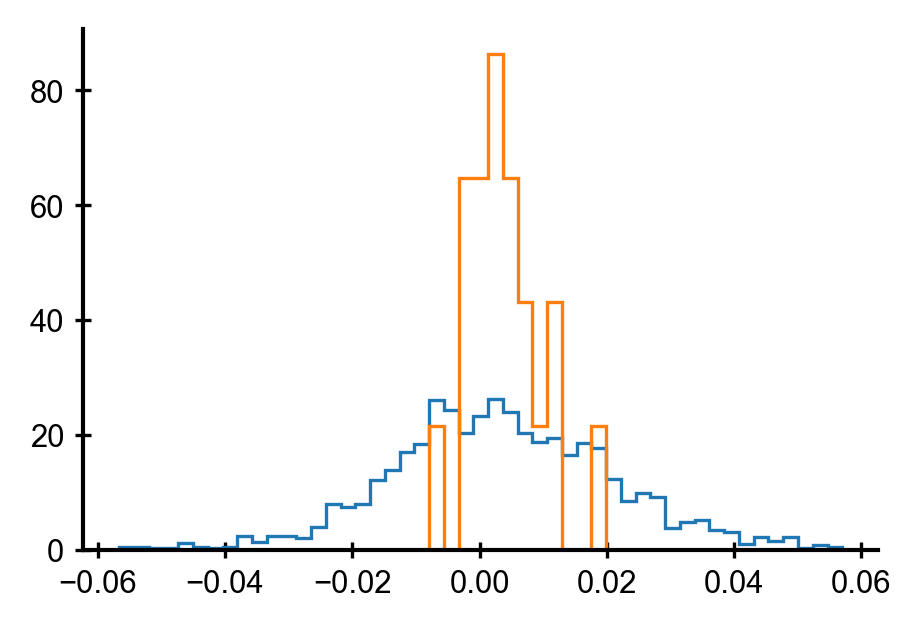

In [19]:
J2 = np.load('data/Human_nskew_9.npz')['J2']
J2diag = [J2[alpha, alpha, alpha] for alpha in range(naminoacids)]
bins = np.linspace(np.amin(J2), np.amax(J2))
plt.hist(J2.flatten(), density=True, histtype='step', bins=bins)
plt.hist(J2diag, density=True, histtype='step', bins=bins);

In [111]:
list(zip(np.load('data/Human_nskewdiag_9.npz')['J2'], J2diag))

[(0.005528579350366695, 0.006989415527834285),
 (-0.000490488510589386, -0.007566881525718562),
 (0.004746111563919675, 0.00960861251187901),
 (0.003457890011867693, 0.005908306975252388),
 (0.00011441873709671727, -0.0021344630454764226),
 (0.006017145887626679, 0.006978661140310664),
 (0.013773023874094438, 0.01936753975114878),
 (-0.001436246058026596, -0.0022720288923674136),
 (0.0008751561144371233, 0.002550564223574996),
 (0.002105243600159295, 0.0034507075171602785),
 (0.0037598803093053575, 0.0010071808361185397),
 (0.00045871615905420196, -0.0007060915746779927),
 (0.0018890560215912796, 0.001530306691775807),
 (0.009619951255021778, 0.0121945972209229),
 (0.0007462292826030457, 0.0015228379066869859),
 (0.0035611366550557582, 0.005001476133051156),
 (0.00749708308767569, 0.01265655979448924),
 (-0.00010223717932330546, -0.0008469126802771246),
 (0.008270760354473253, 0.004324884805089397),
 (0.0005611679924984609, -0.0026048652136603737)]

In [20]:
[''.join(row) for row in map_numbertoaa(sample_matrices['test'][energies['test'] < -10])]

['GAAAAAAGA',
 'AAAAAAGAP',
 'GPGPPPPEP',
 'LRLLALLLL',
 'RLLALLLLL',
 'LLALLLLLL',
 'LALLLLLLA',
 'PLAPPPQPP',
 'PPPQPPASP',
 'PPPPGPTAP',
 'SPSLSSSSS',
 'PSLSSSSSS',
 'SLSSSSSSS',
 'LSSSSSSSS',
 'SSSSSSSSS',
 'SSSSSSSSN',
 'SSSSSSSNA',
 'GCSSSSSSS',
 'SSSSSSSAS',
 'SSSSSSASL',
 'GRPGGGRGG',
 'PPGRPGGGG',
 'TPAPGPPPP',
 'PAPGPPPPP',
 'APGPPPPPP',
 'PGPPPPPPP',
 'GPPPPPPPA',
 'PPPPPPPAP',
 'PPPPPPAPP',
 'PPPPPAPPQ',
 'PPPPAPPQQ',
 'PPQQQPPPP',
 'PQQQPPPPP',
 'QQQPPPPPP',
 'QQPPPPPPP',
 'QPPPPPPPA',
 'PPPPPPPAP',
 'PPPPPPAPP',
 'PPPPPAPPP',
 'PPPPAPPPG',
 'PPPAPPPGP',
 'PPAPPPGPG',
 'PAPPPGPGP',
 'APPPGPGPA',
 'PPPGPGPAP',
 'PPGPGPAPP',
 'PPPPPPPQV',
 'PPPGPAPAA',
 'PPGPAPAAA',
 'PGPPPPASP',
 'GPPPPASPP',
 'PPPPASPPG',
 'AAGAGGGGG',
 'AGAGGGGGG',
 'GAGGGGGGG',
 'AGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGA',
 'GGGGGGGAG',
 'GGGGGGAGG',
 'GGGGGAGGG',
 'GGGGAGGGG',
 'GGGAGGGGG',
 'GGAGGGGGG',
 'HAAAAAAAA',
 'AAAAAAAAA',
 'AAAA

In [40]:
len([''.join(row) for row in map_numbertoaa(sample_matrices['test'][energies['test'] < -15])])

154

In [34]:
[np.mean(energies[dataset]) for dataset in datasets]

[-2.1713909870793495,
 -1.797020033252432,
 -2.0204479399259125,
 -2.1570303708287377]